In [1]:
import torch
from snn_delays.snn import SNN
from snn_delays.experimental_models.snn_binary import TH_BinarySNN, BinarySNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.train_utils import train, get_device, propagate_batch
from snn_delays.utils.visualization_utils import plot_raster
from snn_delays.utils.test_behavior import tb_save_max_last_acc
import matplotlib.pyplot as plt

device = get_device()

# For reproducibility
torch.manual_seed(10)

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [3]:
### DATASET

# Parameters
dataset = 'stmnist'
total_time = 50
batch_size = 1024

# Resized dataloader
# DATASET
DL = DatasetLoader(dataset=dataset,
                   caching='memory',
                   num_workers=0,
                   batch_size=batch_size,
                   total_time=total_time)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

[ToFrame(sensor_size=(10, 10, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


In [8]:
#snn_full = ModelLoader('full_weights_stmnist50_SNN_l1_1d1.t7_874820143884892_max_92epoch','exp_snn2chip', batch_size, device, True) # without bias
snn_full = ModelLoader('full_weights_bias_(64, 1)stmnist50_l1_1d1.t7_8546762589928058_max_100epoch','exp_snn2chip', batch_size, device, True) # with bias

snn_full.to(device)
snn_full.bias = True
snn_full.test(train_loader)

### SPIKING NEURAL NETWORK
structure = snn_full.structure
dataset_dict["time_ms"] = 2e3
loss_fn = snn_full.loss_fn

print(loss_fn)

binary_mode = 'binary'

snn = BinarySNN(dataset_dict=dataset_dict, structure=structure, connection_type='f',
          delay=None, delay_type='', tau_m='normal', binary_mode=binary_mode,
          reset_to_zero=True, win=total_time, bias=True,
          loss_fn=loss_fn, batch_size=batch_size, device=device,
          debug=True)
snn.set_network()

snn.input2spike_th = None

#snn.to(device)
snn.model_name = 'trainable_threshold_' + snn.model_name

if snn_full.bias:
    weight_taus = [(name, w) for name, w  in snn.named_parameters() if 'th' not in name]
    weight_taus_origin = [(name, w) for name, w  in snn_full.named_parameters() if 'th' not in name]
else:
    weight_taus = [(name, w) for name, w  in snn.named_parameters() if 'th' not in name and 'bias' not in name]
    weight_taus_origin = [(name, w) for name, w  in snn_full.named_parameters() if 'th' not in name]

for (name_src, param_src), (name_dst, param_dst) in zip(weight_taus_origin, weight_taus):
    assert name_src == name_dst, f"Parameter mismatch: {name_src} != {name_dst}"
    param_dst.data.copy_(param_src.data)

print(weight_taus)

snn.to(device)

num_epochs = 100
lr = 1e-3
ckpt_dir = 'exp_snn2chip'

train(snn, train_loader, test_loader, lr, num_epochs, dropout=0.0, 
    test_behavior=tb_save_max_last_acc, ckpt_dir=ckpt_dir, scheduler=(10, 0.95), test_every=1, freeze_taus=True)


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
Instance of <class 'snn_delays.snn.SNN'> loaded successfully
Test Loss: 1.0725475947062175
Avg spk_count per neuron for all 50 time-steps 12.85764217376709
Avg spk per neuron per layer [12.85764169813017]
Test Accuracy of the model on the test samples: 67.602

mem_sum

[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407


AssertionError: Parameter mismatch: f1_o.weight != f0_f1.bias

In [6]:
snn_full.f0_f1

Linear(in_features=200, out_features=64, bias=False)

Test Loss: 1.5886229276657104
Avg spk_count per neuron for all 50 time-steps 15.352697372436523
Avg spk per neuron per layer [15.352697841726618]
Test Accuracy of the model on the test samples: 57.122


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
tensor(0.1189, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1997, device='cuda:0', grad_fn=<MeanBackward0>)


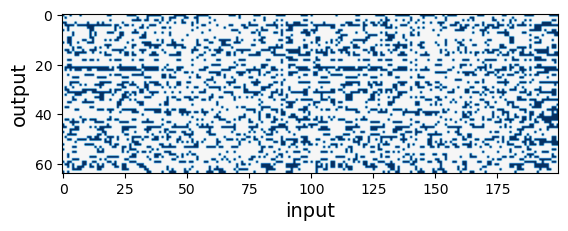

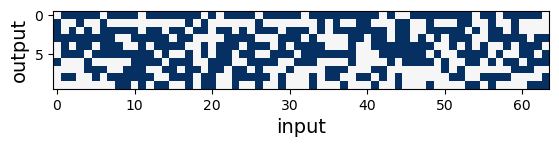

Test Loss: 1.6088847517967224
Avg spk_count per neuron for all 50 time-steps 15.352697372436523
Avg spk per neuron per layer [15.352697841726618]
Test Accuracy of the model on the test samples: 57.122



In [46]:
from snn_delays.utils.train_utils import copy_snn
from snn_delays.utils.visualization_utils import plot_param, plot_distributions

# snn_test = copy_snn(snn, batch_size)
# snn_test.debug = True
a, b = snn.test(test_loader)

snn_test = SNN(dataset_dict=dataset_dict, structure=structure, connection_type='f',
          delay=None, delay_type='', tau_m='normal',
          reset_to_zero=True, win=total_time,
          loss_fn=loss_fn, batch_size=batch_size, device=device,
          debug=True)
snn_test.set_network()

weight_taus = [(name, w) for name, w  in snn_test.named_parameters() if 'th' not in name]
for (name_src, param_src), (name_dst, param_dst) in zip(snn.named_parameters(), weight_taus):
    assert name_src == name_dst, f"Parameter mismatch: {name_src} != {name_dst}"
    param_dst.data.copy_(param_src.data)

w_params = [w for name, w  in snn_test.named_parameters() if 'f' in name]

for w in w_params:
    scale = w.abs().mean()
    print(scale)
    if binary_mode == 'binary':
        w.data = (w.data > 0.0).float().mul(scale).mul(0.3)
    #w.data = (w.data > 0.0).float().mul(scale)
    elif binary_mode == 'sign':
        w.data = w.data.mul(scale).sign().mul(scale)
    elif binary_mode == 'relu':
        w.data = w.data.clamp(0, 1).mul(scale)
        #w.data = w.data
    #w.data = (w.data > 0.0).float().mul(scale*0.3)

for w in w_params:
    plot_param(w, '2D')
    plt.show()

a, b =snn_test.test(test_loader)
